### Exercise 7.8.1
In this excercise we extend the 401k DAG to include a link from U to D and look at it's new properties.

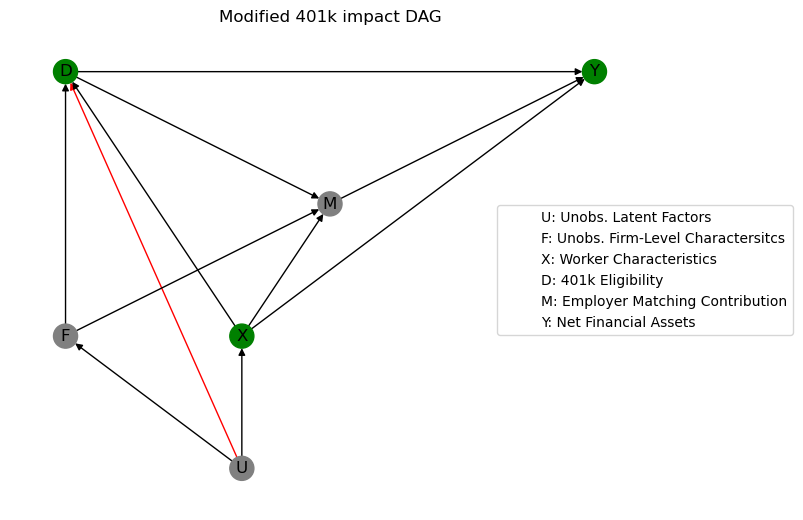

In [27]:
import networkx as nx
from pgmpy.base.DAG import DAG
import matplotlib.patches as mpatches
import pylab as plt

g401k = nx.DiGraph([('U', 'F'),
                      ('U', 'X'),
                      ('U', 'D'),
                      ('F', 'D'),
                      ('F', 'M'),
                      ('X', 'D'),
                      ('X', 'M'),
                      ('X', 'Y'),
                      ('M', 'Y'),
                      ('D', 'M'),
                      ('D', 'Y'),])

nodes = ['U', 'F', 'X', 'D', 'M','Y']
node_descriptions = {
    'U': 'Unobs. Latent Factors',
    'F': 'Unobs. Firm-Level Charactersitcs',
    'X': 'Worker Characteristics',
    'D': '401k Eligibility',
    'M': 'Employer Matching Contribution',
    'Y': 'Net Financial Assets'
}
observed = [0, 0, 1, 1, 0, 1]
poss = [[0,0], [-0.5,0.5], [0,0.5],[-0.5,1.5],[0.25,1], [1,1.5]]
pos = {nodes[i]: poss[i] for i in range(len(nodes))}
colors = ["green" if i == 1 else "grey" for i in observed]
edge_colors = ['red' if edge == ('U', 'D') else 'black' for edge in g401k.edges()]
G = DAG(g401k)
nx.draw(G, with_labels=True, node_color = colors, pos = pos, edge_color =edge_colors)
plt.title("Modified 401k impact DAG")
plt.legend(handles=[mpatches.Patch(color='white', label=f"{k}: {v}") for k, v in node_descriptions.items()],
           loc='center left', bbox_to_anchor=(0.75, 0.5))
plt.show()

#### ASEM of new graph
We can trivially state the ASEM using the parent child relationship.
$U = f_U(\epsilon_U)$\
$F = f_F(\{U\}, \epsilon_F)$\
$X = f_X(\{U\}, \epsilon_X)$\
$D = f_X(\{U, F, X\}, \epsilon_D)$\
$M = f_M(\{X, F, D\}, \epsilon_M)$\
$Y = f_Y(\{X, M, D\}, \epsilon_Y)$

The total joint distribution $p(u,f,x,d,m,y)$ can also be easily extracted by working up the tree according to the ASEMs.
$$p(u,f,x,d,m,y) = p(u)\cdot p(f|u)\cdot p(x|u) \cdot p(d|u,f,x) \cdot p(m|x,f,d) \cdot p(y|x,m,d)$$

Given the model we can see that given U (but not D), F and X must be independent. Similarily, if we isolate Y by conditioning on D M and X F and U should be independent relative Y. These independences are given by the local markov property. These can be hard to test given that much of the data is unobserved.

#### Counterfactual graph
See figure below for graph. The ASEM is again easily found through fixing.

$U = f_U(\epsilon_U)$\
$F = f_F(\{U\}, \epsilon_F)$\
$X = f_X(\{U\}, \epsilon_X)$\
$D = f_X(\{U, F, X\}, \epsilon_D)$\
$M = f_M(\{X, F, d\}, \epsilon_M)$\
$Y = f_Y(\{X, M(d), d\}, \epsilon_Y)$

We can see from the graph that the set {F,X} is a blocking set, the superset {F,X,U} is also valid. {X,M} is not valid as M is a collider on the path D <- F -> M <- d. So by combining the information we gained from conditioning on M with the applied treatment information we could make predictions about F and thereby D.

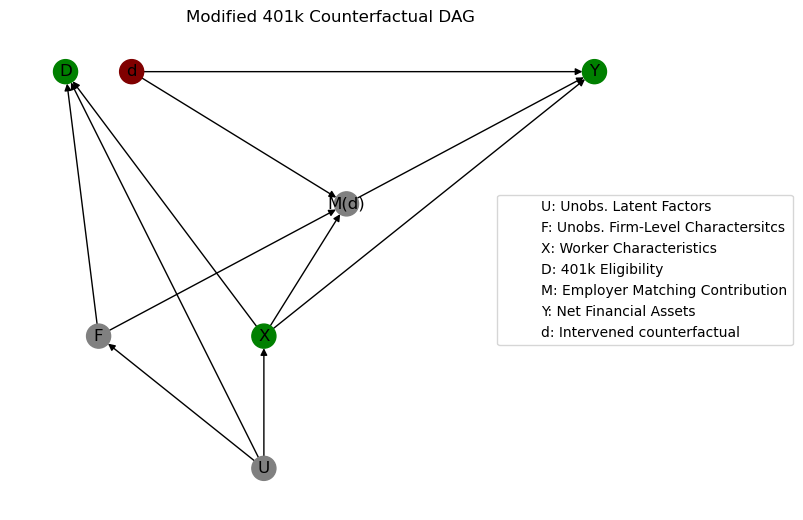

In [29]:
g401kCF = nx.DiGraph([('U', 'F'),
                      ('U', 'X'),
                      ('U', 'D'),
                      ('F', 'D'),
                      ('F', 'M(d)'),
                      ('X', 'D'),
                      ('X', 'M(d)'),
                      ('X', 'Y'),
                      ('M(d)', 'Y'),
                      ('d', 'M(d)'),
                      ('d', 'Y'),])

nodes = ['U', 'F', 'X', 'D', 'M(d)','Y','d']
node_descriptions = {
    'U': 'Unobs. Latent Factors',
    'F': 'Unobs. Firm-Level Charactersitcs',
    'X': 'Worker Characteristics',
    'D': '401k Eligibility',
    'M': 'Employer Matching Contribution',
    'Y': 'Net Financial Assets',
    'd': 'Intervened counterfactual'
}
observed = [0, 0, 1, 1, 0, 1, 2]
poss = [[0,0], [-0.5,0.5], [0,0.5],[-0.6,1.5],[0.25,1], [1,1.5], [-0.4,1.5]]
pos = {nodes[i]: poss[i] for i in range(len(nodes))}
colors = ["green" if i == 1 else "maroon" if i == 2 else "grey" for i in observed]
G = DAG(g401kCF)
nx.draw(G, with_labels=True, node_color = colors, pos = pos)
plt.title("Modified 401k Counterfactual DAG")
plt.legend(handles=[mpatches.Patch(color='white', label=f"{k}: {v}") for k, v in node_descriptions.items()],
           loc='center left', bbox_to_anchor=(0.75, 0.5))
plt.show()

#### Factual DAG backdoor paths D to Y
Backdoor paths starting in F:\
D <- F -> M -> Y\
D <- F -> U -> X -> Y\
D <- F -> U -> X -> M -> Y\

Backdoor paths starting in U:\
D <- U -> X -> Y\
D <- U -> X -> M -> Y\
D <- U -> F -> M -> Y\

Backdoor paths starting in X:\
D <- X -> Y\
D <- X <- U -> F -> M -> Y\
D <- X -> M -> Y

Trivial overkill set {F, U, X}
Smaller sets {F, X}

We may not condition on M since it is a descendent of D.